# **ML Lifecycle**
### This notebook combines the analysis, cleaning, preprocessing, visualization, pipeline generation and model training process into functions that can be used for different datasets

#### Dataset features must include - "processed_text", "priority", "urgency"

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score, StratifiedKFold



In [104]:
df = pd.read_csv('../csv/oversampled_data.csv')
df.sample(3)

,label,processed_text,priority,urgency,type,queue
8437,NaN,"invoice difference. Dear Customer Service, I ...",medium,not_urgent,Request,Billing and Payments
9561,NaN,Re: URGENT: Users randomly losing access to re...,high,urgent,NaN,NaN
3362,0.0,Chat sorting does not adhere to the most recen...,low,not_urgent,NaN,NaN


## Analysis

In [105]:
def analysis(df):
    print(f'Shape : {df.shape}\n')
    print(f'Columns : {df.columns}\n')
    print(f"Sample: \n{df.sample(3)}\n")
    print(f"Null values: \n{df.isnull().sum()}\n")

analysis(df)

Shape : (11904, 6)

Columns : Index(['label', 'processed_text', 'priority', 'urgency', 'type', 'queue'], dtype='object')

Sample: 
      label                                     processed_text priority  \
7584    NaN  Urgent: Network failure. Dear IT Services Cust...     high   
778     1.0  Improperly Displayed Pricing for Bundled Products   medium   
6826    0.0           Non-critical script deprecation warnings      low   

         urgency     type       queue  
7584      urgent  Problem  IT Support  
778   not_urgent      NaN         NaN  
6826  not_urgent      NaN         NaN  

Null values: 
label              4819
processed_text        0
priority              0
urgency               0
type              10348
queue             10348
dtype: int64



## Cleaning

In [106]:
def clean_data(df):
    df = df[['processed_text', 'priority', 'urgency']]
    df = df.rename(columns={'processed_text': 'text'})
    df['priority'] = df['priority'].apply(lambda x: x.lower())
    df['label'] = df['urgency'].apply(lambda x: 1 if x == 'urgent' else 0)
    return df 

df = clean_data(df)
df.sample(3)

,text,priority,urgency,label
2506,Timestamps Missing for Some Messages,medium,not_urgent,0
9376,Re: Urgent Issue: Role Assignment Failing in P...,high,urgent,1
8085,Urgent Request for Jira Ticket Modification. D...,high,urgent,1


## Visualization - using TF-IDF Vectorizer

In [107]:
def word_importance_chart(ax, df, title):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df['text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()

In [108]:
def distribution_chart(ax, df, column, title, category):
    sns.countplot(data=df, x=column, ax=ax)
    ax.set_title(title)

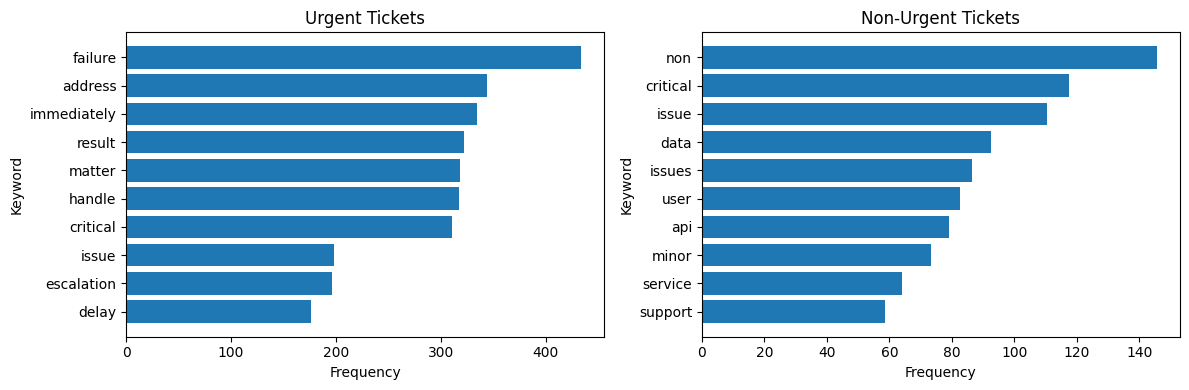

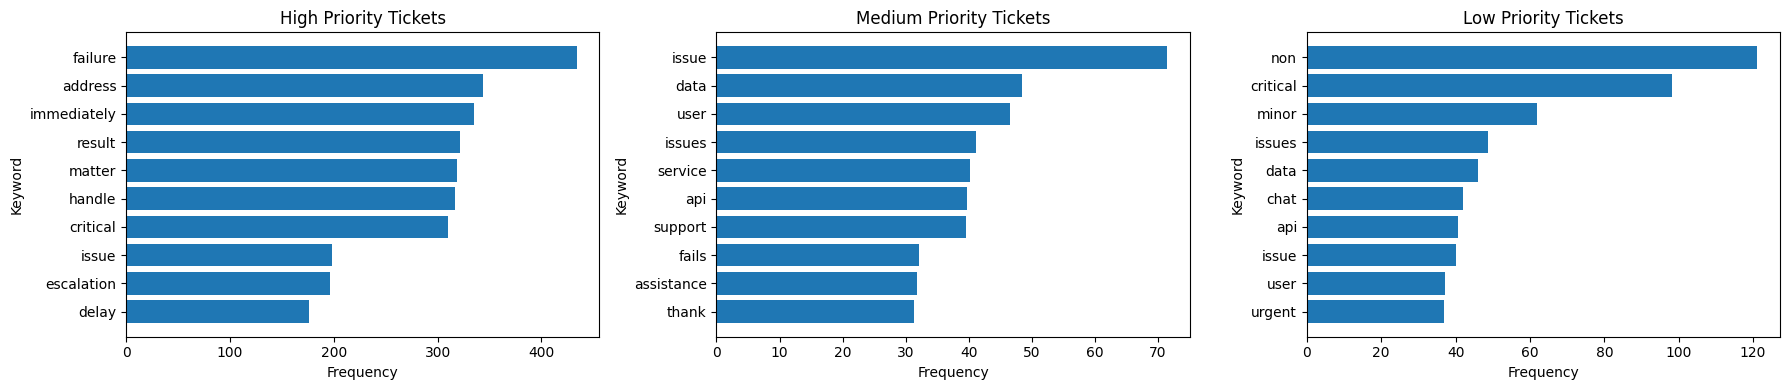

In [109]:
urgent_df = df[df['urgency'] == 'urgent']
non_urgent_df = df[df['urgency'] == 'not_urgent']

high_priority_df = df[df['priority'] == 'high']
medium_priority_df = df[df['priority'] == 'medium']
low_priority_df = df[df['priority'] == 'low']

# Urgent/Non-Urgent Tickets
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
word_importance_chart(axs[0], urgent_df, 'Urgent Tickets')
word_importance_chart(axs[1], non_urgent_df, 'Non-Urgent Tickets')
plt.tight_layout()

# Priority Tickets
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
word_importance_chart(axs[0], high_priority_df, 'High Priority Tickets')
word_importance_chart(axs[1], medium_priority_df, 'Medium Priority Tickets')
word_importance_chart(axs[2], low_priority_df, 'Low Priority Tickets')
plt.tight_layout()


urgency
urgent        6235
not_urgent    5669
Name: count, dtype: int64

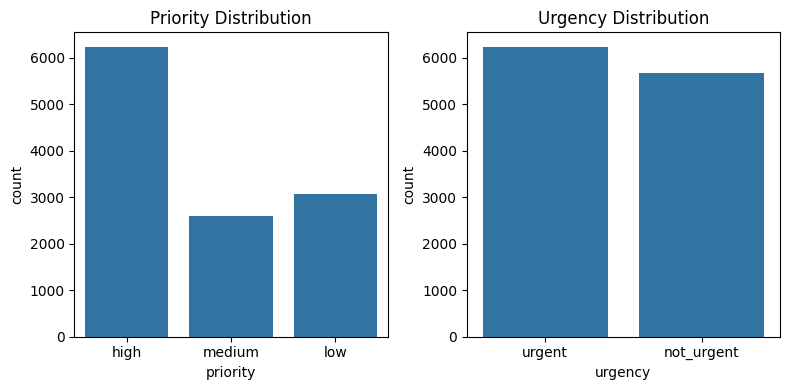

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
distribution_chart(axs[0], df, 'priority', 'Priority Distribution', 'priority')
distribution_chart(axs[1], df, 'urgency', 'Urgency Distribution', 'urgency')
plt.tight_layout()

# print number of urgent and non-urgent tickets
df['urgency'].value_counts()

# **Using Priority**

## Train-Test Split 

In [75]:
def get_train_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

In [76]:
X_train, X_test, y_train, y_test = get_train_test_data(df[['text']], df['priority'])

X_train shape: (8854, 1)
X_test shape: (2214, 1)


## Model Training - using Pipeline

In [77]:
# Training the models
def train_model(model, tdidf_vectorizer, X_train, y_train, X_test, y_test):
    text_transformer = Pipeline([
    ('tfidf', tdidf_vectorizer)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )
    pipeline =Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
    return pipeline

In [78]:
# Logisitic Regression
pipeline_logreg = train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(),
    X_train, 
    y_train,
    X_test,
    y_test
)

Classification Report: 
              precision    recall  f1-score   support

        high       0.89      0.89      0.89      1062
         low       0.75      0.80      0.77       629
      medium       0.62      0.57      0.60       523

    accuracy                           0.79      2214
   macro avg       0.75      0.75      0.75      2214
weighted avg       0.79      0.79      0.79      2214



In [80]:
# Support Vector Machine
pipeline_svm = train_model(
    SVC(random_state=42), 
    TfidfVectorizer(),
    X_train, 
    y_train,
    X_test,
    y_test
)

Classification Report: 
              precision    recall  f1-score   support

        high       0.93      0.88      0.90      1062
         low       0.75      0.83      0.79       629
      medium       0.63      0.62      0.63       523

    accuracy                           0.81      2214
   macro avg       0.77      0.78      0.77      2214
weighted avg       0.81      0.81      0.81      2214



## Testing with example texts

In [89]:
# Example of prediction
example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    "this is a reminder to fill out your kaizen immediately"
    ],
    columns=['text']
)

print(f"Logistic Regression Prediction: \n{pipeline_logreg.predict(example_text)}")
print(f"SVM Prediction: \n{pipeline_svm.predict(example_text)}")


Logistic Regression Prediction: 
['high' 'high' 'medium' 'high' 'medium' 'medium' 'high' 'high' 'medium'
 'low' 'low']
SVM Prediction: 
['high' 'low' 'medium' 'medium' 'medium' 'medium' 'high' 'high' 'low'
 'low' 'low']


# **Using Urgency**

## Train-Test Split 

In [111]:
X = df[['text']]
y = df['label']
X_train_urgency, X_test_urgency, y_train_urgency, y_test_urgency = get_train_test_data(X, y)

X_train shape: (9523, 1)
X_test shape: (2381, 1)


## Model Training - using Pipeline

In [112]:
# Logisitic Regression
pipeline_logreg = train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(),
    X_train_urgency, 
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1117
           1       0.95      0.85      0.90      1264

    accuracy                           0.90      2381
   macro avg       0.90      0.90      0.90      2381
weighted avg       0.90      0.90      0.90      2381



In [113]:
# Support Vector Machine
pipeline_svm = train_model(
    SVC(random_state=42, kernel='linear'),
    TfidfVectorizer(), 
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1117
           1       0.95      0.87      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.91      0.91      0.91      2381
weighted avg       0.91      0.91      0.91      2381



In [114]:

example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    columns=['text']
)

print(f"Logistic Regression Prediction: \n{pipeline_logreg.predict(example_text)}\n")
print(f"SVM Prediction: \n{pipeline_svm.predict(example_text)}")

Logistic Regression Prediction: 
[1 1 0 1 0 0 1 0 0 0]

SVM Prediction: 
[1 1 0 1 0 0 1 0 0 0]


# Cross Validation using K-Fold

In [115]:

# Function to train and validate the model using K-Fold Cross-Validation
def cross_validate_model(model, tfidf_vectorizer, X, y, cv=5, scoring='precision'):
    text_transformer = Pipeline([
        ('tfidf', tfidf_vectorizer)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Stratified K-Fold to maintain class distribution
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Use cross_val_score to evaluate accuracy
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=skf, 
        scoring=scoring
    )

    print(f"Cross-Validation {scoring.capitalize} Scores: {scores}")
    print(f"Mean: {np.mean(scores):.4f}")
    print(f"Standard Deviation: {np.std(scores):.4f}")

    return scores


In [116]:
# Testing accuracy
scored_svm = cross_validate_model(
    SVC(random_state=42, kernel='linear'), 
    TfidfVectorizer(),
    df[['text']], 
    df['urgency'].map({'urgent': 1, 'not_urgent': 0})
)

Cross-Validation <built-in method capitalize of str object at 0x00000222B8A62FB0> Scores: [0.93706294 0.9527972  0.93838028 0.94363792 0.93996569]
Mean: 0.9424
Standard Deviation: 0.0057


## Hyperparameter Tuning - using GridSearchCV

In [117]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(model, X_train, y_train, param_grid):
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='precision',
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_


In [118]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear'],
    'preprocessor__text_tfidf__tfidf__max_features': [None],
    'preprocessor__text_tfidf__tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
}

In [25]:
best_model = hyperparameter_tuning(
    SVC(random_state=42),
    X_train_urgency,
    y_train_urgency,
    param_grid
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   5.1s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.8s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   5.0s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.8s
[CV] END classifier__C=0.1, classifier__kern

### **Result** : Model best parameters are
kernel : linear

C value : 0.1

TF-IDF Max features : None

TF-IDF n-gram range: (1,2)


### Tuning using RBF kernel

In [119]:
print("Using RBF Kernel")
pipeline_best_svm_rbf =  train_model(
    SVC(gamma='scale', kernel='rbf', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using RBF Kernel
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1117
           1       0.98      0.85      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.92      0.92      0.91      2381
weighted avg       0.92      0.91      0.91      2381



In [120]:

example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    columns=['text']
)
print(f"SVM Prediction with RBF: \n{pipeline_best_svm_rbf.predict(example_text)}")

SVM Prediction with RBF: 
[1 0 0 0 0 0 1 1 0 0]


### Tuning using Linear Kernel

In [132]:
print("Using Linear Kernel")
pipeline_best_svm_linear =  train_model(
    SVC(kernel='linear', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using Linear Kernel
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1117
           1       0.96      0.89      0.92      1264

    accuracy                           0.92      2381
   macro avg       0.92      0.92      0.92      2381
weighted avg       0.92      0.92      0.92      2381



### Tuning with Logistic Regression Model

In [ ]:
print("Using Logistic Regression")
pipeline_best_logreg =  train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using Logistic Regression
Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1117
           1       0.96      0.86      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.91      0.91      0.91      2381
weighted avg       0.91      0.91      0.91      2381



### Using Stacked Classifier

In [ ]:
# stacked model
estimators = [
    ('svm', pipeline_best_svm_linear),
    ('logreg', pipeline_best_logreg)
]

meta_model = LogisticRegression(random_state=42, max_iter=1000)

print("Using Stacked Model")

stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model
)

stacked_model.fit(X_train_urgency, y_train_urgency)



print(f"Classification Report: \n{classification_report(y_test_urgency, y_pred)}")

Using Stacked Model


ValueError: Specifying the columns using strings is only supported for dataframes.

## Testing Manually

In [124]:
def test_model(model):
    example_text = pd.DataFrame([
        'This is an urgent issue',
        'I need help with my account right now without delay',
        'I have a question about my account',
        'I cannot access my account. Please help me',
        'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
        "Query regarding my account. Please help me",
        "The server is down. Please fix it as soon as possible",
        "System Issue. Need help before the end of the day",
        "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
        "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
        "this is a reminder to fill out your kaizen immediately by EOD"
        ],
    columns=['text'])
    
    true_labels = [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
    predictions = model.predict(example_text)
    print(f"Predictions: {predictions.tolist()}")
    print(f"True Labels: {true_labels}")
    print(f"Classification Report: \n{classification_report(true_labels, predictions,labels=[1, 0])}")

In [125]:
test_model(pipeline_best_svm_linear)

Predictions: [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         8
           0       0.43      1.00      0.60         3

    accuracy                           0.64        11
   macro avg       0.71      0.75      0.63        11
weighted avg       0.84      0.64      0.65        11



In [127]:
test_model(pipeline_svm)


Predictions: [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         8
           0       0.43      1.00      0.60         3

    accuracy                           0.64        11
   macro avg       0.71      0.75      0.63        11
weighted avg       0.84      0.64      0.65        11



In [128]:
test_model(pipeline_logreg)


Predictions: [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.62      0.77         8
           0       0.50      1.00      0.67         3

    accuracy                           0.73        11
   macro avg       0.75      0.81      0.72        11
weighted avg       0.86      0.73      0.74        11



In [134]:
test_model(pipeline_best_logreg)


Predictions: [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         8
           0       0.43      1.00      0.60         3

    accuracy                           0.64        11
   macro avg       0.71      0.75      0.63        11
weighted avg       0.84      0.64      0.65        11



In [149]:
test_model(stacked_model)


Predictions: [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         8
           0       0.43      1.00      0.60         3

    accuracy                           0.64        11
   macro avg       0.71      0.75      0.63        11
weighted avg       0.84      0.64      0.65        11



In [430]:
# Cross validation after hyperparameter tuning
scored_svm_rbf = cross_validate_model(
    SVC(kernel='linear', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    df[['text']],
    df['urgency'].map({'urgent': 1, 'not_urgent': 0})
)


Cross-Validation <built-in method capitalize of str object at 0x1027bd0b0> Scores: [0.94320487 0.937751   0.94147326 0.94053518 0.94651867]
Mean: 0.9419
Standard Deviation: 0.0029


# Storing the model - using Pickle

In [150]:
import pickle
 # storing pipeline for normal svm and then for the best svm
with open("../models/svm_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_svm, file)

with open("../models/best_svm_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_best_svm_linear, file)

with open("../models/logreg_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_logreg, file)
    
with open("../models/best_logreg_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_best_logreg, file)
    
with open("../models/stacked_model.pkl", "wb") as file:
    pickle.dump(stacked_model, file)